In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import spikeinterface as si  # import core only

global_job_kwargs = dict(n_jobs=4, chunk_duration="1s")
si.set_global_job_kwargs(**global_job_kwargs)

In [ ]:
from spikeinterface.extractors import read_spikeglx

# Path to the folder containing imec0.ap.bin/meta
# spikeglx_probe_folder = r"D:\Neuropixels\9153_01292025_tagging_g0\9153_01292025_tagging_g0_imec0"    ## When running on Windows
# spikeglx_probe_folder = "Z:\Koji\9153_01292025_tagging_g0\9153_01292025_tagging_g0_imec0"            ## When running on Windows
spikeglx_probe_folder = "/Volumes/annex3/Koji/9153_01292025_tagging_g0/9153_01292025_tagging_g0_imec0" ## When running on Mac

# List available streams (usually just 'ap')
streams = read_spikeglx.get_streams(spikeglx_probe_folder)
print("Available streams:", streams)

# Load the AP stream
recording = read_spikeglx(spikeglx_probe_folder, stream_id='imec0.ap')
recording

Available streams: (['imec0.ap'], ['imec0.ap'])


SpikeGLXRecordingExtractor: 384 channels - 29999.709091 Hz - 1 segments - 56,460,520 samples 
                            1,882.04s (31.37 minutes) - int16 dtype - 40.38 GiB

In [9]:
## LFP extraction
from spikeinterface.preprocessing import bandpass_filter, resample

# FIlter tthe LFP data to 0.5-600Hz
recording_filt = bandpass_filter(recording, freq_min=0.5, freq_max=600)

# Downsample to 2500 Hz
recording_ds = resample(recording_filt, 2500)

# Select every 4th channel
channel_ids = recording_ds.channel_ids[::4]
recording_LFP = recording_ds.channel_slice(channel_ids=channel_ids)
recording_LFP

# Select one channel per shank (in total 4 channels)
channel_ids = recording_ds.channel_ids[47::96]
recording_LFP = recording_ds.channel_slice(channel_ids=channel_ids)
recording_LFP

ChannelSliceRecording: 4 channels - 2500.0Hz - 1 segments - 4,705,088 samples 
                       1,882.04s (31.37 minutes) - int16 dtype - 35.90 MiB

(1251,)
(1250,)
(1251,)
(1250,)
(1251,)
(1250,)
(1251,)
(1250,)


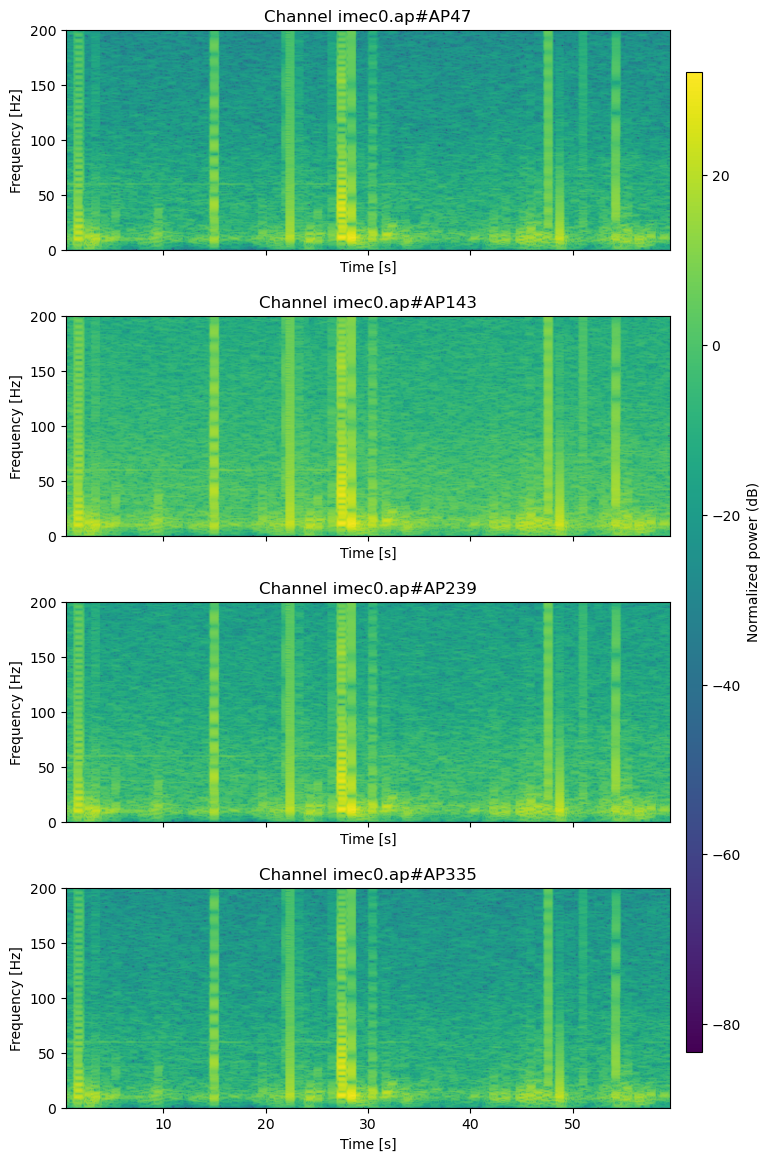

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.optimize import curve_fit

# 1) Prepare your baseline‐removal machinery (same as before)
def exp_baseline(f, A, b, C):
    return A * np.exp(-b * f) + C

fs = 2500             # LFP data downsampled from 30000 --> 2500 Hz
nperseg = 2500        # 1 sec window, 1 Hz freq resolution (nperseg/fs will be the frequency resolution)
noverlap = 2250       # (2250 overlap slide window --> 0.9 sec overlapping --> 0.1 sec time bins)
start, end = 0, int(fs*60)
traces = recording_LFP.get_traces(start_frame=start, end_frame=end)

n_ch = 4
max_f = 200

fig, axes = plt.subplots(4, 1, figsize=(8, 14), sharex=True)  
axes = axes.flatten()

for i, ax in enumerate(axes[:n_ch]):
    # compute PSD‐spectrogram
    f, t, Sxx = spectrogram(
        traces[:, i], fs=fs,
        nperseg=nperseg, noverlap=noverlap,
        scaling='density'
    )

    # fit & remove exp baseline
    mean_psd = Sxx.mean(axis=1)
    print(np.shape(mean_psd))
    p0 = (mean_psd[0], 0.01, np.min(mean_psd))
    fit_mask = (f >= 1) & (f <= 2500)   # or 1–30 Hz depending on your data
    print(np.shape(mean_psd[fit_mask]))
    p0 = (mean_psd[fit_mask][0], 0.01, np.min(mean_psd[fit_mask]))
    popt, _ = curve_fit(exp_baseline, f[fit_mask], mean_psd[fit_mask], p0=p0)
    baseline = exp_baseline(f, *popt)

    Sxx_norm = Sxx / baseline[:, None]
    Sxx_norm[Sxx_norm <= 0] = 1e-12

    mask = f <= max_f
    f_masked = f[mask]
    Sxx_masked = Sxx_norm[mask, :]  # This is only 0-200Hz part

    # plot only 0–200 Hz
    pcm = ax.pcolormesh(
        t, f_masked, 10*np.log10(Sxx_masked),
        shading='gouraud'
    )
    ax.set_title(f'Channel {recording_LFP.channel_ids[i]}')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [s]')
    ax.set_ylim(0, max_f)           # <— lock to 0–200 Hz

# 2) Reserve space on the right and draw one colorbar for all panels
fig.subplots_adjust(right=0.88, hspace=0.3, wspace=0.2)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(pcm, cax=cbar_ax, label='Normalized power (dB)')

plt.show()
